# Buiding your document scanner.

Hey folks, how has the opencv and deep learning journey been, this time around, with open cv, we would create a simple document scanner just like the popularly used cam-scanner app. The idea is quite easy since you and i reckon that a document is four sided, we get the position of the edges and use this to grab the document itself leaving out the useless image background.

### simple Pipeline : load image >> detect edges  & grab position >> use position on image

###### Deep dive.

###### Import packages
first we import the packages which we might need to process the image. The threshold_local function might seem new to you but i assure you its nothing special in this code rather than to add a kind of  black and white feel to the scanned image. The function is from the scikit image package.

In [9]:
# import packages
from skimage.filters import threshold_local
import numpy as np
import cv2
import imutils

###### Process image.
Here we load in the image, and keep a copy as well. Here the copy which i named original is very vital to obtain a clear and untampered scan of the image, this way we are safe. To process the image, i resize to a reasonable ratio, next i gray scale the the image to reduce color  as well as blurr it(i.e helps greatly to remove high frequency noise from the image background), all these are done only to find the Edges of the document.

In [11]:
#load in the image
image = cv2.imread("images/questions.jpg")
orig  = image.copy()
#Resize the image.
height = image.shape[0]
width = image.shape[1]
ratio = 0.2
width = int(ratio * width)
height = int(ratio * height)
image = cv2.resize(image,(width, height))

#find edges in the image.
gray_scaled = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#blurr the image
gray_scaled = cv2.GaussianBlur(gray_scaled,(5,5),0)

#Edge detection
edged = cv2.Canny(gray_scaled,50, 200)

cv2.imshow("Image", image)
cv2.imshow("Edges detected", edged)
cv2.waitKey(0)
cv2.destroyAllWindows()

##### Find the contours.
The contours are found using the cv2.findcontours(). Next, we grab the contours using the imutils library, lastly we sort out the grabbed contours with the knowldge that the largest contour area is most likely the paper. In this scenario, i preserved the largest 5 

In [12]:
# find contours in the edged image. keep only the largest contours.
contours = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
# grab contours
contours = imutils.grab_contours(contours)
# select contours based on size.
contours = sorted(contours, key=cv2.contourArea, reverse = True)[:5]

######  Futher processing on contours.
First we loop over the contours and find the perimeter, This is necessary to approximate the perimeter into points. When this is done, we finally search for a contour with exactly 4 points which is most likely the paper in it's approximated rectangular shape.
When this is done, we pick up the co-ordinates of those points and then initialize it to be the paper outline.

In [13]:
# loop over the contours.
for contour in contours:
    perimeter = cv2.arcLength(contour, True)
    # approximate your contour
    approximation = cv2.approxPolyDP(contour, 0.02*perimeter, True)
    
    # if our contour has 4 points, then surely, it should be the paper.
    if len(approximation) == 4:
        paper_outline = approximation
        break

######  Draw what you have.
You have the co-ordinates, next step is to draw the contours, easy as pie.

In [14]:
# Draw the found contour.
cv2.drawContours(image,[paper_outline],-1,(225,0,0),2)
cv2.imshow("Found outline", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

###### DONE??
The question in your mind, are we done?, well you might say yes seeing you have the contour well set around the image. The answer is no, to have the best scanned form of the image, we want a 90 degree view of the image especially if it is tilted. To this effect, we will create a function to handle this task.

#### pipeline : arrange points >> Mark out points >> Pick point from true image.

######  arrange_points function.
The method to do this i assure you is quite simple, many credits to cv posts of Adrian Rosebrock(PhD). The intution behind this function is that we pick up co-ordinares of the four edges of the document, and arrange it as to where we think it should be, i've taken sometime to give a pictorial representation of the description.

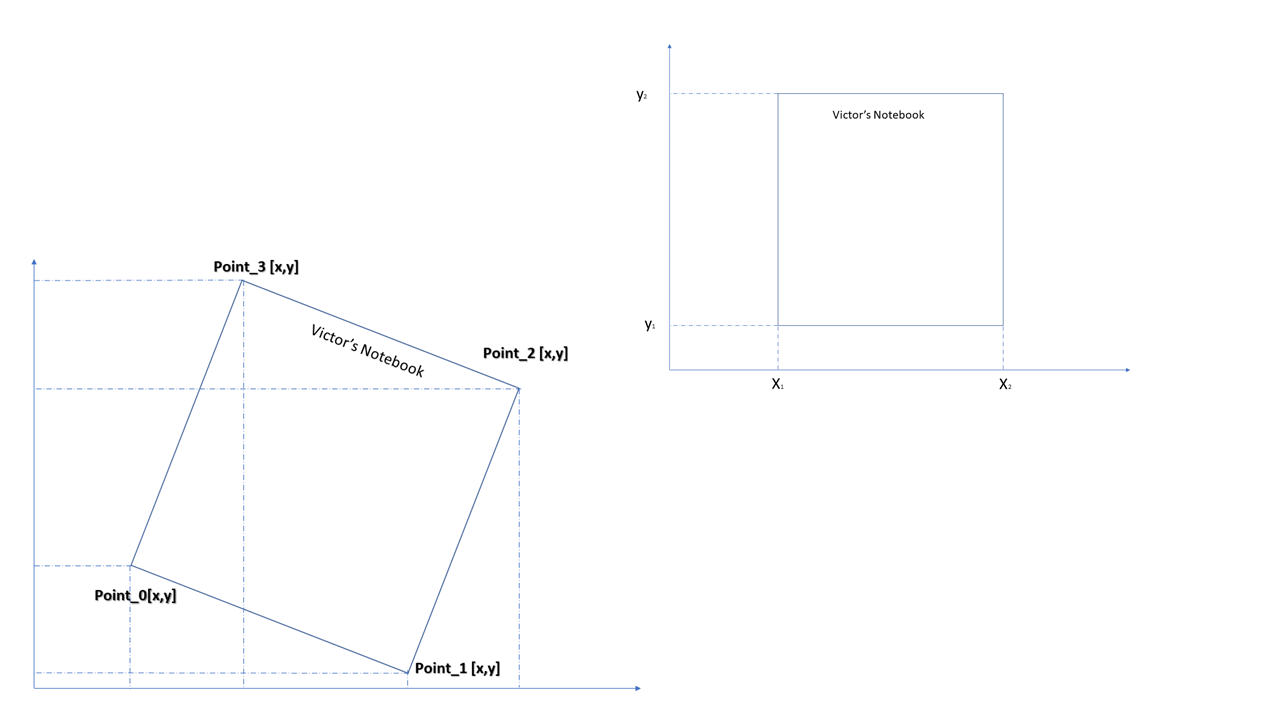

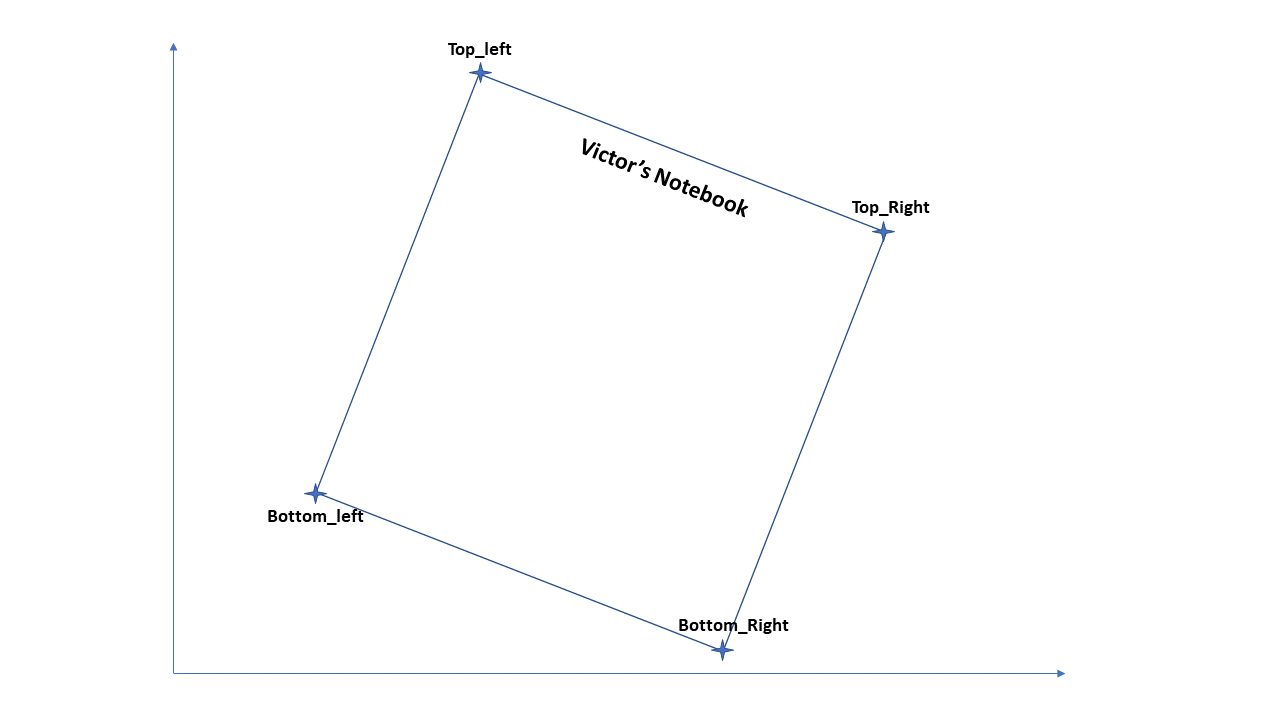

###### Sum of points
1). From diagram above, we can see that the largest sum of point's co-ordinate(X,Y) is the Top Right Corner.

2). Smallest sum of points The Bottom Left Point.

###### Difference of Points.
3). The largest difference of points is the Top left Corner

4). The smallest difference of points is the Bottom Left Corner.

###### The Code.
The function takes in the numbeer of points, next, i initialize a numpy array to represent the rectangle, The array is just a 4 by 2 matrix, since we have 4 points and 2 co-ordinates (X,Y) each. Finally i register in my points of the rectangle as explained above( sum of points and difference of points). lastly, i Return the co-ordinates of the Rectangle properly.

In [15]:
def arrange_points(points):
    # initialize a list of co-ordinates that will be ordered
    # first entry is top-left point, second entry is top-right
    # third entry is bottom-right, forth/last point is the bottom left point.
    rectangle = np.zeros((4,2), dtype = "float32")
    
    # bottom left point should be the smallest sum
    # the top-right point will have the largest sum of point.
    sum_points= points.sum(axis =1)
    rectangle[0] = points[np.argmin(sum_points)]
    rectangle[2] = points[np.argmax(sum_points)]
    
    
    #bottom right will have the smallest difference
    #top left will have the largest difference.
    diff_points = np.diff(points, axis=1)
    rectangle[1] = points[np.argmin(diff_points)]
    rectangle[3] = points[np.argmax(diff_points)]
    
    
    # return order of co-ordinates.
    return rectangle
        

###### Set four points.
This function is quite easy, The idea here is to of course, straighten the paper as well as extract only the needed region. Here, the inputs are 1) The image itself and the points or co-ordinates. First, we arrange points of the Functions with the first function we created called "arrange_points". next i assigned the points accordingly as i've arranged the points before and named them well also. 

###### Small Calculations.
For the calculations, it's nothing other than distance between two points to find the length of each side. With this, i am able to build my confidence, of positions and prevent Tuning the image wrongly. 
The destination as the name implies is the new view of the image. where [0,0], indicates the Top-left corner.Next, [Max-width - 1,0], indicates the top-right corner, also we have the [maxwidth -1, maxheight-1], for the Bottom Right corner, and lastly the Bottom left coner as [0, maxheight - 1].

######  Transformation Matrix
The deed is done, the labour is over, what we need finalize is the transformation matrix using cv2.getPerspectiveTransform(), which takes in the rectangle of points and the destination. Now that we have the matrix, we apply it using the cv2.warpPerspective(), which takes the image you gave the function, Transformation Matrix and lastly the (width and length) of the proposed scan. All done, return the warped image

In [16]:
# set four points.
def set_four_points(image, points):
    # obtain order of points and unpack.
    rectangle = arrange_points(points)
    (top_left,top_right,bottom_right,bottom_left) = rectangle
    # let's compute width of the rectangle.
    # using formular for distance between two points
    left_height = np.sqrt(((top_left[0]-bottom_left[0])**2) + ((top_left[1]-bottom_left[1])**2))
    right_height = np.sqrt(((top_right[0]-bottom_right[0])**2) + ((top_right[1]-bottom_right[1])**2))
    top_width = np.sqrt(((top_right[0]-top_left[0])**2) + ((top_right[1]-top_left[1])**2))
    bottom_width = np.sqrt(((bottom_right[0]-bottom_left[0])**2) + ((bottom_right[1]-bottom_left[1])**2))
    
    maxheight = max(int(left_height), int(right_height))
    maxwidth  = max(int(top_width), int(bottom_width))
    
    destination = np.array([
        [0,0],
        [maxwidth -1,0],
        [maxwidth -1, maxheight-1],
        [0, maxheight - 1]], dtype = "float32")
    
    
    matrix = cv2.getPerspectiveTransform(rectangle, destination)
    warped = cv2.warpPerspective(image, matrix, (maxwidth,maxheight))
    
    return warped   

###### Apply Functions
We've created the functions, so we apply this to the original image which we saved initially. the second input is the outline of the paper. I rescaled the paper outline back to it's original by removing the ratio scaling i did at the very beginning. To obtain a black and white feel to the image, the Threshold local comes in but of course it is not needed at all if you want a colored scan of the image. lastly, i resize and display.

In [17]:
warped = set_four_points(orig, paper_outline.reshape(4,2)*(1/ratio))
#warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
#threshold = threshold_local(warped, 11, offset=10, method="gaussian")
#warped = (warped > threshold).astype("uint8") * 255

#show the original and scanned images
print("Image Reset in progress")
cv2.imshow("Original", cv2.resize(orig,(width, height)))
cv2.imshow("Scanned",cv2.resize(warped,(width, height)))
cv2.waitKey(0)

Image Reset in progress


-1

### Good job!!, You've just created your own scanner app.

feel free to convert to a mobile app and upload to a store.....